In [ ]:
#Instal Liblaries
!pip install tensorflow numpy matplotlib opencv-python

In [2]:
!unrar x /content/data.rar


UNRAR 6.11 beta 1 freeware      Copyright (c) 1993-2022 Alexander Roshal


Extracting from /content/data.rar

Creating    data                                                      OK
Extracting  data/label_class_dict.xlsx                                     0%  OK 
Creating    data/png                                                  OK
Creating    data/png/test                                             OK
Extracting  data/png/test/417661_271914.jpg                                0%  OK 
Extracting  data/png/test/417661_271916.jpg                                0%  OK 
Extracting  data/png/test/417661_271922.jpg                                0%  OK 
Extracting  data/png/test/417661_271923.jpg                                0%  OK 
Extracting  data/png/test/417661_271924.jpg                                0%  OK 
Extracting  data/png/test/417661_271935.jpg                                1%  OK 
Extracting  data/png/test/

In [3]:
# --- 0. Setup Libraries ---
import tensorflow as tf  # Framework deep learning utama
import numpy as np  # Operasi array dan matematika
import matplotlib.pyplot as plt  # Visualisasi dan plotting
import os  # Operasi sistem file
from tensorflow.keras.preprocessing.image import load_img, img_to_array  # Load dan preprocess gambar
from tensorflow.keras import layers, Model  # Layer dan model neural network
import tensorflow.keras.backend as K  # Backend operations keras
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau  # Callback training
from google.colab import files  # Upload/download file di Colab
import cv2  # Computer vision untuk overlay mask


Menampilkan contoh data training:


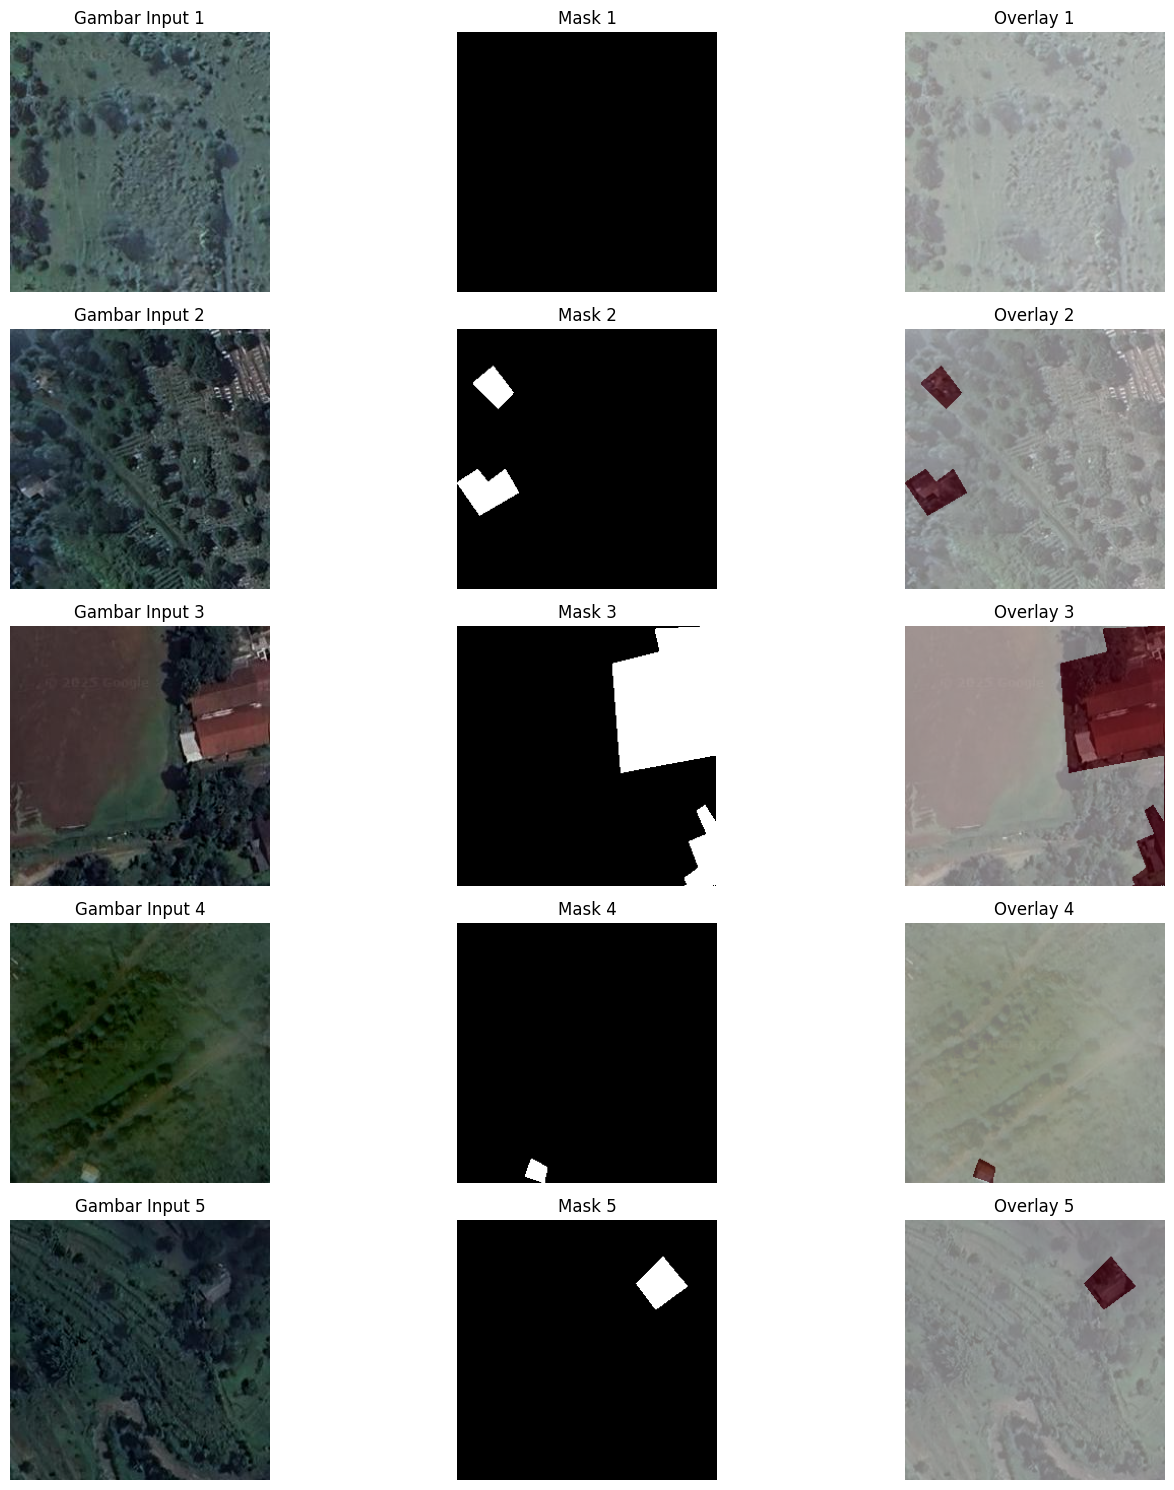

In [5]:
# --- 1. Data Loading dan Augmentasi ---
# Konfigurasi parameter utama
IMG_SIZE = 256  # Ukuran gambar
BATCH_SIZE = 8  # Jumlah sampel per batch

def load_image_mask(img_path, mask_path):
    """
    Memuat gambar dan mask dari path yang diberikan

    Args:
        img_path: Path ke gambar input
        mask_path: Path ke mask/label gambar

    Returns:
        img: Gambar yang sudah dinormalisasi (0-1)
        mask: Mask binary (0 atau 1)
    """
    # Konversi bytes ke string untuk kompatibilitas tf.numpy_function
    img_path = img_path.decode('utf-8')
    mask_path = mask_path.decode('utf-8')

    # Memuat gambar dengan ukuran yang sudah ditentukan
    img = load_img(img_path, target_size=(IMG_SIZE, IMG_SIZE))
    mask = load_img(mask_path, target_size=(IMG_SIZE, IMG_SIZE), color_mode='grayscale')

    # Konversi ke array dan normalisasi
    img = img_to_array(img) / 255.0  # Normalisasi pixel ke range 0-1

    # Konversi mask ke binary (0 atau 1) dengan threshold 0.5
    mask = (img_to_array(mask) / 255.0 > 0.5).astype('float32')

    return img, mask

def load_dataset_paths(img_dir, mask_dir):
    """
    Mengumpulkan semua path gambar dan mask dari direktori

    Args:
        img_dir: Direktori berisi gambar input
        mask_dir: Direktori berisi mask/label

    Returns:
        img_paths: List path gambar
        mask_paths: List path mask yang sesuai
    """
    img_paths = []
    mask_paths = []

    # Iterasi melalui semua file dalam direktori gambar
    for fname in sorted(os.listdir(img_dir)):
        img_path = os.path.join(img_dir, fname)
        mask_path = os.path.join(mask_dir, fname)

        # Hanya tambahkan jika mask file ada
        if os.path.exists(mask_path):
            img_paths.append(img_path)
            mask_paths.append(mask_path)
    return img_paths, mask_paths

def tf_load_image_mask(img_path, mask_path):
    """
    Wrapper TensorFlow untuk load_image_mask function
    Diperlukan untuk integrasi dengan tf.data pipeline
    """
    # Menggunakan tf.numpy_function untuk menjalankan Python function
    img, mask = tf.numpy_function(load_image_mask, [img_path, mask_path], [tf.float32, tf.float32])

    # Set shape secara eksplisit untuk optimasi TensorFlow
    img.set_shape([IMG_SIZE, IMG_SIZE, 3])  # RGB image
    mask.set_shape([IMG_SIZE, IMG_SIZE, 1])  # Grayscale mask

    return img, mask

def augment_image_mask_pair(image, mask):
    """
    Melakukan augmentasi data pada pasangan gambar-mask
    Penting: Augmentasi yang sama harus diterapkan pada gambar dan mask

    Args:
        image: Gambar input
        mask: Mask yang sesuai

    Returns:
        image: Gambar yang sudah diaugmentasi
        mask: Mask yang sudah diaugmentasi (sinkron dengan gambar)
    """
    # Memastkan tipe data konsisten
    image = tf.cast(image, tf.float32)
    mask = tf.cast(mask, tf.float32)

    # Horizontal flip dengan probabilitas 50%
    if tf.random.uniform(()) > 0.5:
        image = tf.image.flip_left_right(image)
        mask = tf.image.flip_left_right(mask)  # Mask juga harus di-flip

    # Vertical flip dengan probabilitas 30%
    if tf.random.uniform(()) > 0.7:
        image = tf.image.flip_up_down(image)
        mask = tf.image.flip_up_down(mask)

    # Augmentasi warna hanya pada gambar (bukan mask) - dikurangi intensitasnya
    seed = tf.random.uniform([2], maxval=1000, dtype=tf.int32)
    image = tf.image.stateless_random_brightness(image, max_delta=0.1, seed=seed)  # Dikurangi dari 0.15 ke 0.1
    image = tf.image.stateless_random_contrast(image, lower=0.9, upper=1.1, seed=seed)  # Dikurangi range
    image = tf.clip_by_value(image, 0.0, 1.0)

    # Pastikan mask tetap binary setelah augmentasi
    mask = tf.round(mask)
    mask = tf.clip_by_value(mask, 0.0, 1.0)

    return image, mask

# --- Memuat Path Dataset ---
train_img_paths, train_mask_paths = load_dataset_paths("data/png/train", "data/png/train_labels")
val_img_paths, val_mask_paths = load_dataset_paths("data/png/val", "data/png/val_labels")

# --- Membuat tf.data Pipeline ---
# Training dataset dengan augmentasi
train_dataset = tf.data.Dataset.from_tensor_slices((train_img_paths, train_mask_paths))
train_dataset = train_dataset.shuffle(len(train_img_paths))  # Shuffle untuk variasi training
train_dataset = train_dataset.map(tf_load_image_mask, num_parallel_calls=tf.data.AUTOTUNE)
train_dataset = train_dataset.map(augment_image_mask_pair, num_parallel_calls=tf.data.AUTOTUNE)
train_dataset = train_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

# Validation dataset tanpa augmentasi
val_dataset = tf.data.Dataset.from_tensor_slices((val_img_paths, val_mask_paths))
val_dataset = val_dataset.map(tf_load_image_mask, num_parallel_calls=tf.data.AUTOTUNE)
val_dataset = val_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

# --- Melihat Contoh Data ---
def visualize_samples(dataset, num_samples=5):
    """
    Menampilkan contoh gambar dan mask dari dataset

    Args:
        dataset: tf.data.Dataset
        num_samples: Jumlah sampel yang akan ditampilkan
    """
    plt.figure(figsize=(15, 3*num_samples))

    for i, (images, masks) in enumerate(dataset.take(1)):
        for j in range(min(num_samples, len(images))):
            # Pastikan gambar dalam range [0,1] untuk visualisasi
            img_to_show = tf.clip_by_value(images[j], 0.0, 1.0)

            # Gambar asli
            plt.subplot(num_samples, 3, j*3 + 1)
            plt.imshow(img_to_show)
            plt.title(f'Gambar Input {j+1}')
            plt.axis('off')

            # Mask
            plt.subplot(num_samples, 3, j*3 + 2)
            plt.imshow(masks[j].numpy().squeeze(), cmap='gray')
            plt.title(f'Mask {j+1}')
            plt.axis('off')

            # Overlay
            plt.subplot(num_samples, 3, j*3 + 3)
            plt.imshow(img_to_show)
            plt.imshow(masks[j].numpy().squeeze(), cmap='Reds', alpha=0.5)
            plt.title(f'Overlay {j+1}')
            plt.axis('off')

    plt.tight_layout()
    plt.show()

# Menampilkan contoh data training
print("\nMenampilkan contoh data training:")
visualize_samples(train_dataset)

In [6]:
# --- 2. Definisi Model U-Net ---
def conv_block(x, filters, dropout=False):
    """
    Membuat blok konvolusi dengan dua layer Conv2D, Batch Normalization, dan ReLU.
    Jika dropout diaktifkan, Dropout layer akan ditambahkan untuk mengurangi overfitting.
    """
    # Layer konvolusi pertama dengan filter tertentu
    x = layers.Conv2D(filters, 3, padding='same')(x)  # Padding 'same' memastikan ukuran output sama dengan input
    x = layers.BatchNormalization()(x)  # Normalisasi batch untuk meningkatkan stabilitas training
    x = layers.ReLU()(x)  # Aktivasi ReLU untuk non-linearitas

    # Layer konvolusi kedua
    x = layers.Conv2D(filters, 3, padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)

    # Dropout untuk mengurangi overfitting
    if dropout:
        x = layers.Dropout(0.3)(x)  # Dropout rate 0.3 menghilangkan 30% neuron secara acak selama training
    return x

def build_better_unet(input_shape):
    """
    Membangun model U-Net dengan arsitektur encoder-decoder.
    Encoder mengekstraksi fitur, decoder merekonstruksi gambar.
    """
    # Input layer dengan shape yang diberikan
    inp = layers.Input(input_shape)  # Input berupa tensor dengan shape tertentu (e.g., HxWxC)

    # Encoder: Blok konvolusi + MaxPooling untuk downsampling
    c1 = conv_block(inp, 64)  # Blok konvolusi pertama dengan 64 filter
    p1 = layers.MaxPool2D()(c1)  # Downsampling menggunakan MaxPooling

    c2 = conv_block(p1, 128)  # Blok konvolusi kedua dengan 128 filter
    p2 = layers.MaxPool2D()(c2)  # Downsampling lagi

    c3 = conv_block(p2, 256, dropout=True)  # Blok ketiga dengan dropout untuk mengurangi overfitting
    p3 = layers.MaxPool2D()(c3)  # Downsampling lebih lanjut

    c4 = conv_block(p3, 512, dropout=True)  # Blok keempat dengan dropout

    # Decoder: Upsampling + Concatenation untuk menggabungkan fitur dari encoder
    u3 = layers.UpSampling2D()(c4)  # Upsampling untuk meningkatkan resolusi
    u3 = layers.Concatenate()([u3, c3])  # Menggabungkan fitur dari encoder dan decoder
    c5 = conv_block(u3, 256)  # Blok konvolusi setelah concatenation

    u2 = layers.UpSampling2D()(c5)  # Upsampling lagi
    u2 = layers.Concatenate()([u2, c2])  # Menggabungkan fitur dari level sebelumnya
    c6 = conv_block(u2, 128)

    u1 = layers.UpSampling2D()(c6)  # Upsampling terakhir
    u1 = layers.Concatenate()([u1, c1])  # Menggabungkan fitur dari level awal
    c7 = conv_block(u1, 64)

    # Output layer: Menghasilkan mask binary dengan aktivasi sigmoid
    out = layers.Conv2D(1, 1, activation='sigmoid')(c7)  # Output berupa mask dengan nilai antara 0 dan 1
    return Model(inp, out)  # Mengembalikan model dengan input dan output yang telah didefinisikan

In [7]:
# --- 3. Fungsi Loss dan Metrik ---
def dice_loss(y_true, y_pred):
    """
    Menghitung Dice Loss, yang digunakan untuk mengukur kesamaan antara prediksi dan ground truth.
    Semakin kecil nilai loss, semakin baik prediksi.
    """
    smooth = 1.  # Nilai smooth untuk menghindari pembagian dengan nol

    # Meratakan tensor y_true dan y_pred menjadi vektor 1D
    y_true_f = K.flatten(y_true)  # Flatten ground truth
    y_pred_f = K.flatten(y_pred)  # Flatten prediksi

    # Menghitung intersection (irisan) antara ground truth dan prediksi
    intersection = K.sum(y_true_f * y_pred_f)  # Perkalian elemen-elemen yang sesuai

    # Menghitung Dice Loss
    return 1 - (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)
    # Rumus: 1 - (2 * intersection + smooth) / (sum ground truth + sum prediksi + smooth)

def bce_dice_loss(y_true, y_pred):
    """
    Menggabungkan Binary Cross-Entropy (BCE) Loss dan Dice Loss.
    Digunakan untuk meningkatkan performa model dalam tugas segmentasi.
    """
    # Menghitung Binary Cross-Entropy Loss
    bce = tf.keras.losses.binary_crossentropy(y_true, y_pred)  # BCE mengukur error klasifikasi biner

    # Menggabungkan BCE Loss dan Dice Loss
    return K.mean(bce) + dice_loss(y_true, y_pred)
    # Total loss = Rata-rata BCE Loss + Dice Loss

def dice_coefficient(y_true, y_pred, smooth=1.):
    """
    Menghitung Dice Coefficient, yang digunakan sebagai metrik untuk mengevaluasi performa model.
    Nilai Dice Coefficient berkisar antara 0 hingga 1, semakin tinggi semakin baik.
    """
    # Meratakan tensor y_true dan y_pred menjadi vektor 1D
    y_true_f = K.flatten(y_true)  # Flatten ground truth
    y_pred_f = K.flatten(y_pred)  # Flatten prediksi

    # Menghitung intersection (irisan) antara ground truth dan prediksi
    intersection = K.sum(y_true_f * y_pred_f)  # Perkalian elemen-elemen yang sesuai

    # Menghitung Dice Coefficient
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)
    # Rumus: (2 * intersection + smooth) / (sum ground truth + sum prediksi + smooth)

In [8]:
# --- 4. Kompilasi dan Pelatihan Model ---
# Membangun model U-Net dengan input shape tertentu (IMG_SIZE x IMG_SIZE x 3)
model = build_better_unet((IMG_SIZE, IMG_SIZE, 3))

# Mengompilasi model dengan optimizer Adam, loss function bce_dice_loss, dan metrik evaluasi
model.compile(optimizer='adam',  # Optimizer Adam digunakan untuk mengoptimalkan bobot model
              loss=bce_dice_loss,  # Menggunakan kombinasi BCE dan Dice Loss
              metrics=[dice_coefficient, tf.keras.metrics.MeanIoU(num_classes=2)])
              # Metrik: Dice Coefficient untuk kesamaan spasial, MeanIoU untuk Intersection over Union

# Menampilkan ringkasan arsitektur model
model.summary()  # Menampilkan struktur model, jumlah parameter, dan layer-layer yang digunakan

# Menyimpan model terbaik ke file dengan nama 'best_unet_model.keras'
MODEL_PATH = 'best_unet_model.keras'

# Definisi callback untuk pelatihan
callbacks = [
    # EarlyStopping: Menghentikan pelatihan jika val_dice_coefficient tidak membaik setelah 20 epoch
    EarlyStopping(monitor='val_dice_coefficient', mode='max', patience=20,
                  restore_best_weights=True, verbose=1),  # Memulihkan bobot terbaik

    # ModelCheckpoint: Menyimpan model terbaik berdasarkan val_dice_coefficient
    ModelCheckpoint(MODEL_PATH, monitor='val_dice_coefficient', mode='max',
                    save_best_only=True, verbose=1),  # Hanya menyimpan model terbaik

    # ReduceLROnPlateau: Mengurangi learning rate jika val_dice_coefficient stagnan
    ReduceLROnPlateau(monitor='val_dice_coefficient', mode='max', factor=0.2,
                      patience=7, min_lr=1e-6, verbose=1)  # Mengurangi LR hingga minimum 1e-6
]

# Jumlah epoch maksimal untuk pelatihan
EPOCHS = 100

# Melatih model menggunakan dataset training dan validasi
history = model.fit(train_dataset,  # Dataset training
                    validation_data=val_dataset,  # Dataset validasi
                    epochs=EPOCHS,  # Jumlah epoch maksimal
                    callbacks=callbacks)  # Callbacks untuk mengontrol pelatihan

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 256, 256,  │      1,792 │ input_layer[0][0] │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 256, 256,  │        256 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu (ReLU)        │ (None, 256, 256,  │          0 │ batch_normalizat… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 256, 256,  │     36,928 │ re_lu[0][0]       │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 256, 256,  │        256 │ conv2d_1[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_1 (ReLU)      │ (None, 256, 256,  │          0 │ batch_normalizat… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 128, 128,  │          0 │ re_lu_1[0][0]     │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 128, 128,  │     73,856 │ max_pooling2d[0]… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128, 128,  │        512 │ conv2d_2[0][0]    │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_2 (ReLU)      │ (None, 128, 128,  │          0 │ batch_normalizat… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 128, 128,  │    147,584 │ re_lu_2[0][0]     │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128, 128,  │        512 │ conv2d_3[0][0]    │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_3 (ReLU)      │ (None, 128, 128,  │          0 │ batch_normalizat… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 64, 64,    │          0 │ re_lu_3[0][0]     │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 64, 64,    │    295,168 │ max_pooling2d_1[… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64, 64,    │      1,024 │ conv2d_4[0][0]  

 Total params: 7,794,177 (29.73 MB)

 Trainable params: 7,788,545 (29.71 MB)

 Non-trainable params: 5,632 (22.00 KB)

Epoch 1/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - dice_coefficient: 0.1056 - loss: 1.2886 - mean_io_u: 0.4943   
Epoch 1: val_dice_coefficient improved from -inf to 0.00245, saving model to best_unet_model.keras
44/44 ━━━━━━━━━━━━━━━━━━━━ 124s 2s/step - dice_coefficient: 0.1062 - loss: 1.2856 - mean_io_u: 0.4943 - val_dice_coefficient: 0.0025 - val_loss: 329.5181 - val_mean_io_u: 8.4669e-04 - learning_rate: 0.0010
Epoch 2/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 419ms/step - dice_coefficient: 0.2064 - loss: 0.9599 - mean_io_u: 0.5082
Epoch 2: val_dice_coefficient improved from 0.00245 to 0.00252, saving model to best_unet_model.keras
44/44 ━━━━━━━━━━━━━━━━━━━━ 20s 453ms/step - dice_coefficient: 0.2066 - loss: 0.9593 - mean_io_u: 0.5080 - val_dice_coefficient: 0.0025 - val_loss: 5.2531 - val_mean_io_u: 0.4993 - learning_rate: 0.0010
Epoch 3/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 423ms/step - dice_coefficient: 0.2337 - loss: 0.9313 - mean_io_u: 0.4822
Epoch 3: val_dice_coefficient did not improve 

Metric yang tersedia: ['dice_coefficient', 'loss', 'mean_io_u', 'val_dice_coefficient', 'val_loss', 'val_mean_io_u', 'learning_rate']


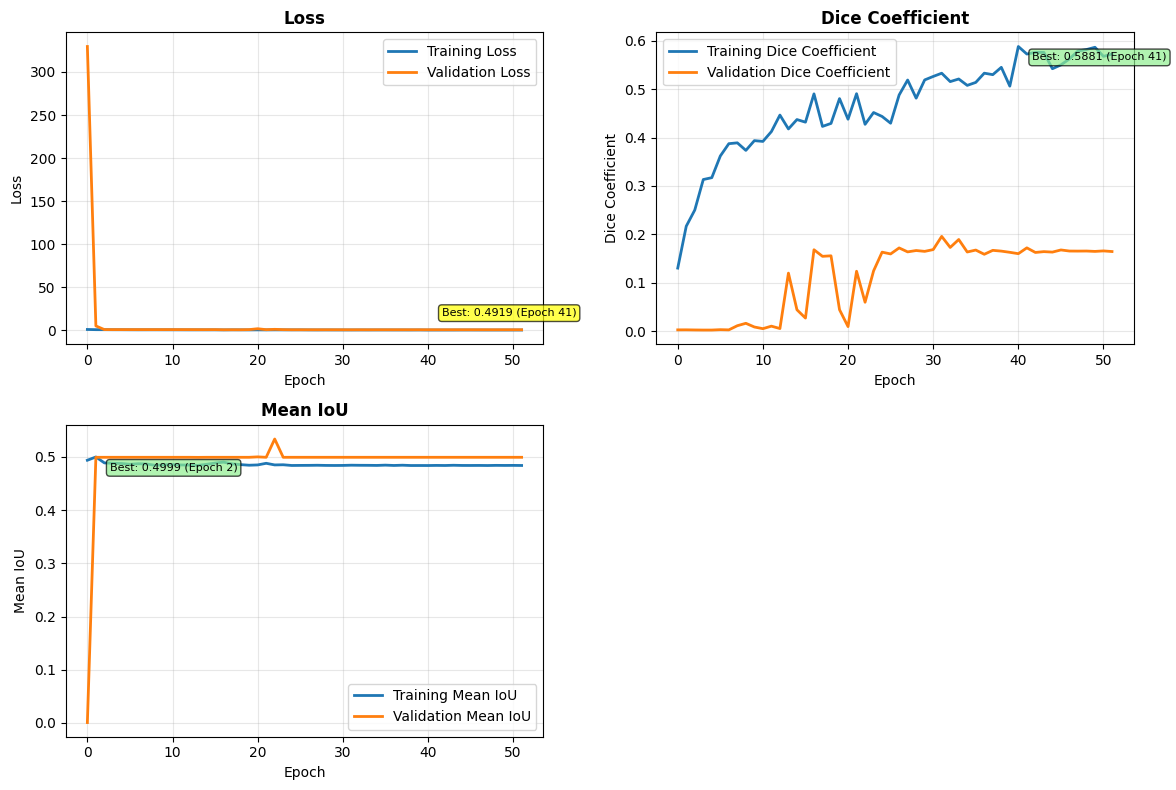


RINGKASAN TRAINING:

Loss:
  Training   - Best: 0.4919 (Epoch 41), Final: 0.5064
  Validation - Best: 0.7961 (Epoch 32), Final: 0.8304

Dice Coefficient:
  Training   - Best: 0.5881 (Epoch 41), Final: 0.5726
  Validation - Best: 0.1956 (Epoch 32), Final: 0.1643

Mean IoU:
  Training   - Best: 0.4999 (Epoch 2), Final: 0.4839
  Validation - Best: 0.5337 (Epoch 23), Final: 0.4993


In [9]:
# --- 5. Plot Training History (Versi Diperbaiki) ---
def plot_history(history):
    """
    Menampilkan grafik training history dengan error handling

    Args:
        history: Keras History object dari model.fit()
    """
    # Dapatkan semua metric yang tersedia
    available_metrics = list(history.history.keys())
    print("Metric yang tersedia:", available_metrics)

    # Tentukan metric yang akan diplot
    metrics_to_plot = []

    # Loss (selalu ada)
    if 'loss' in available_metrics:
        metrics_to_plot.append(('loss', 'Loss', 'loss'))

    # Dice Coefficient
    dice_metrics = [m for m in available_metrics if 'dice' in m.lower() and not m.startswith('val_')]
    if dice_metrics:
        dice_metric = dice_metrics[0]
        metrics_to_plot.append((dice_metric, 'Dice Coefficient', 'dice'))

    # IoU / Mean IoU
    iou_metrics = [m for m in available_metrics if 'iou' in m.lower() and not m.startswith('val_')]
    if not iou_metrics:
        iou_metrics = [m for m in available_metrics if 'mean_io_u' in m.lower() and not m.startswith('val_')]
    if iou_metrics:
        iou_metric = iou_metrics[0]
        metrics_to_plot.append((iou_metric, 'Mean IoU', 'iou'))

    # Accuracy
    acc_metrics = [m for m in available_metrics if 'acc' in m.lower() and not m.startswith('val_')]
    if acc_metrics:
        acc_metric = acc_metrics[0]
        metrics_to_plot.append((acc_metric, 'Accuracy', 'accuracy'))

    # Tentukan layout subplot
    num_plots = len(metrics_to_plot)
    if num_plots <= 2:
        rows, cols = 1, 2
        figsize = (12, 4)
    elif num_plots <= 4:
        rows, cols = 2, 2
        figsize = (12, 8)
    else:
        rows, cols = 2, 3
        figsize = (15, 8)

    plt.figure(figsize=figsize)

    for i, (metric, title, metric_type) in enumerate(metrics_to_plot, 1):
        plt.subplot(rows, cols, i)

        # Plot training metric
        plt.plot(history.history[metric], label=f'Training {title}', linewidth=2)

        # Plot validation metric jika ada
        val_metric = f'val_{metric}'
        if val_metric in available_metrics:
            plt.plot(history.history[val_metric], label=f'Validation {title}', linewidth=2)

        plt.title(title, fontsize=12, fontweight='bold')
        plt.xlabel('Epoch')
        plt.ylabel(title)
        plt.legend()
        plt.grid(True, alpha=0.3)

        # Tambahkan best value annotation
        if metric_type == 'loss':
            best_val = min(history.history[metric])
            best_epoch = history.history[metric].index(best_val) + 1
            plt.annotate(f'Best: {best_val:.4f} (Epoch {best_epoch})',
                        xy=(best_epoch-1, best_val), xytext=(10, 10),
                        textcoords='offset points', fontsize=8,
                        bbox=dict(boxstyle='round,pad=0.3', facecolor='yellow', alpha=0.7))
        else:
            best_val = max(history.history[metric])
            best_epoch = history.history[metric].index(best_val) + 1
            plt.annotate(f'Best: {best_val:.4f} (Epoch {best_epoch})',
                        xy=(best_epoch-1, best_val), xytext=(10, -10),
                        textcoords='offset points', fontsize=8,
                        bbox=dict(boxstyle='round,pad=0.3', facecolor='lightgreen', alpha=0.7))

    plt.tight_layout()
    plt.show()

    # Print summary
    print("\n" + "="*50)
    print("RINGKASAN TRAINING:")
    print("="*50)

    for metric, title, metric_type in metrics_to_plot:
        train_values = history.history[metric]
        val_metric = f'val_{metric}'

        if metric_type == 'loss':
            best_train = min(train_values)
            best_train_epoch = train_values.index(best_train) + 1
            final_train = train_values[-1]

            print(f"\n{title}:")
            print(f"  Training   - Best: {best_train:.4f} (Epoch {best_train_epoch}), Final: {final_train:.4f}")

            if val_metric in available_metrics:
                val_values = history.history[val_metric]
                best_val = min(val_values)
                best_val_epoch = val_values.index(best_val) + 1
                final_val = val_values[-1]
                print(f"  Validation - Best: {best_val:.4f} (Epoch {best_val_epoch}), Final: {final_val:.4f}")

        else:
            best_train = max(train_values)
            best_train_epoch = train_values.index(best_train) + 1
            final_train = train_values[-1]

            print(f"\n{title}:")
            print(f"  Training   - Best: {best_train:.4f} (Epoch {best_train_epoch}), Final: {final_train:.4f}")

            if val_metric in available_metrics:
                val_values = history.history[val_metric]
                best_val = max(val_values)
                best_val_epoch = val_values.index(best_val) + 1
                final_val = val_values[-1]
                print(f"  Validation - Best: {best_val:.4f} (Epoch {best_val_epoch}), Final: {final_val:.4f}")

plot_history(history)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


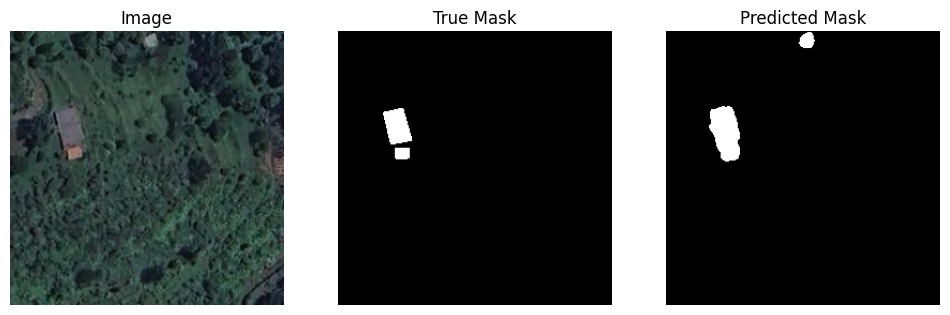

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


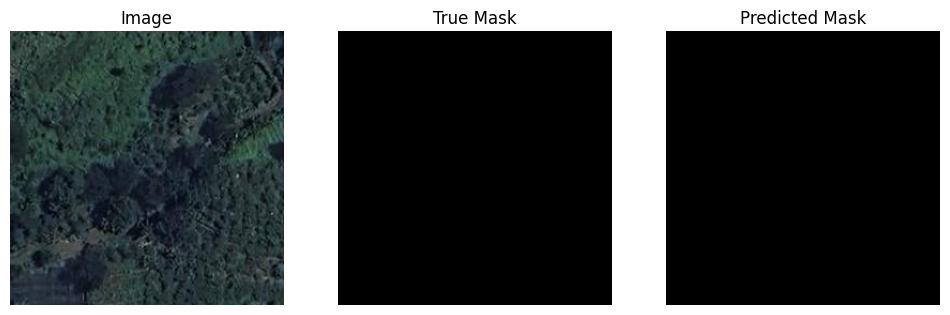

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


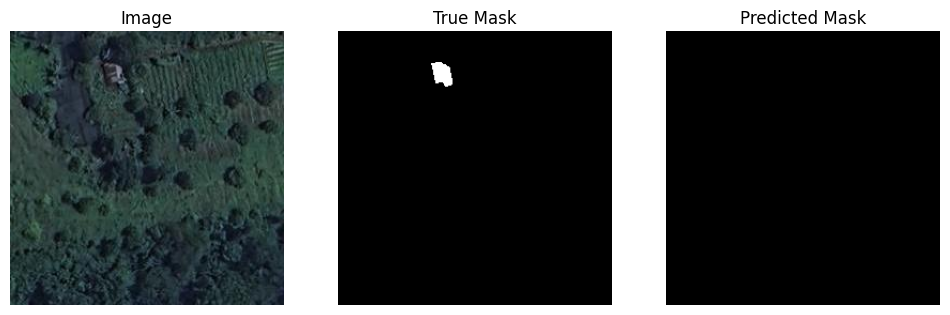

In [11]:
# --- 6. Load Model and Visualize ---
# Load model terbaik dengan custom loss function
best_model = tf.keras.models.load_model(MODEL_PATH, custom_objects={'bce_dice_loss': bce_dice_loss, 'dice_coefficient': dice_coefficient})

# Konversi validation dataset ke numpy array
val_images_np = []
val_masks_np = []
for images, masks in val_dataset.take(1):  # Ambil 1 batch untuk visualisasi
    val_images_np.extend(images.numpy())
    val_masks_np.extend(masks.numpy())
val_images_np = np.array(val_images_np)
val_masks_np = np.array(val_masks_np)

def visualize(idx, model_to_predict, images_arr, true_masks_arr):
    """Fungsi untuk visualisasi hasil prediksi"""
    img = images_arr[idx]
    true_mask = true_masks_arr[idx].squeeze()  # Hapus dimensi ekstra
    pred_mask_prob = model_to_predict.predict(img[None]).squeeze()  # Prediksi probability
    pred_mask_binary = (pred_mask_prob > 0.5).astype(np.float32)  # Konversi ke binary mask

    # Plot gambar asli, mask asli, dan mask prediksi
    titles = ['Image', 'True Mask', 'Predicted Mask']
    plt.figure(figsize=(12, 4))
    for i, (im, title) in enumerate(zip([img, true_mask, pred_mask_binary], titles)):
        plt.subplot(1, 3, i + 1)
        plt.imshow(im, cmap='gray' if i > 0 else None)  # Grayscale untuk mask
        plt.title(title)
        plt.axis('off')
    plt.show()

# Visualisasi beberapa contoh hasil prediksi
for i in range(min(3, len(val_images_np))):
    visualize(i, best_model, val_images_np, val_masks_np)

Saving 2025-06-12 23_20_26-Window.png to 2025-06-12 23_20_26-Window.png
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


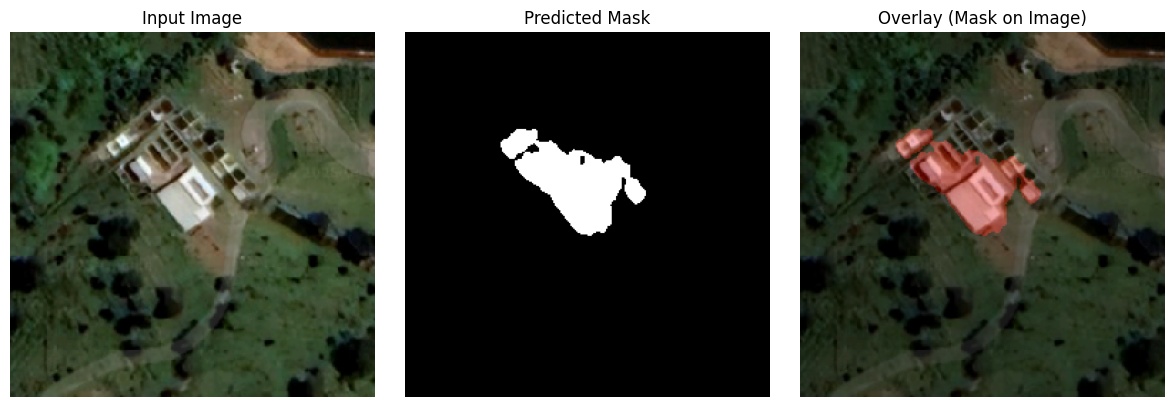

In [12]:
# --- Prediksi pada Gambar Baru ---
#Upload gambar dari komputer lokal
uploaded = files.upload()

# Ambil nama file yang diupload (asumsi hanya 1 file)
img_path = list(uploaded.keys())[0]

#Load dan preprocess gambar
img = load_img(img_path, target_size=(256, 256))  # Resize ke (256, 256)
img_array = img_to_array(img) / 255.0  # Normalisasi pixel ke [0, 1]
img_array = np.expand_dims(img_array, axis=0)  # Tambah batch dimension [1, 256, 256, 3]

#Prediksi mask menggunakan model
pred = model.predict(img_array)[0].squeeze() > 0.5  # Generate binary mask (True/False)

# Konversi binary mask ke 3-channel untuk overlay
mask = np.zeros_like(img_array[0])  # Buat mask kosong dengan shape sama seperti gambar
mask[pred] = [1, 0, 0]  # Set area prediksi (True) ke merah [R, G, B]

# Overlay mask pada gambar asli
overlay = img_array[0] * 0.7 + mask * 0.3  # Blend gambar asli dengan mask (70% asli, 30% mask)

#Visualisasi hasil
plt.figure(figsize=(12, 4))

# Tampilkan gambar input
plt.subplot(1, 3, 1)
plt.imshow(img)
plt.title("Input Image")
plt.axis('off')

# Tampilkan predicted mask
plt.subplot(1, 3, 2)
plt.imshow(pred, cmap='gray')
plt.title("Predicted Mask")
plt.axis('off')

# Tampilkan overlay
plt.subplot(1, 3, 3)
plt.imshow(overlay)
plt.title("Overlay (Mask on Image)")
plt.axis('off')

plt.tight_layout()
plt.show()